## Imports ##

In [22]:
# Imports for pyspark
from pyspark.ml.classification import LinearSVC, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer, IndexToString
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.session import SparkSession
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import col, unix_timestamp, to_date, datediff, expr
from helper_functions import translate_to_file_string
from pyspark.ml.feature import Bucketizer
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.sql import SQLContext


# Import for seaborn
import seaborn as sbs

# Imports for mathlib
%matplotlib inline
import seaborn as sbs
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



## Creating Spark Context ##

In [23]:
spark = (SparkSession
       .builder
       .appName("HumanResources")
       .getOrCreate())
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

## Setting input file ##
Defining dataframe out of the HRDataset file. Renaming of the columns to match the source file.

In [24]:
inputFile = translate_to_file_string("./HRDataset.csv")
# load data file.
# create a DataFrame using an ifered Schema
df = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .csv(inputFile) \
    .withColumnRenamed("_c0", "EmpLastname")\
    .withColumnRenamed("_c1", "EmpFirstname")\
    .withColumnRenamed("_c2", "EmpID")\
    .withColumnRenamed("_c3", "MarriedID")\
    .withColumnRenamed("_c4", "MaritalStatusID")\
    .withColumnRenamed("_c5", "GenderID")\
    .withColumnRenamed("_c6", "EmpStatusID")\
    .withColumnRenamed("_c7", "DeptID")\
    .withColumnRenamed("_c8", "PerfScoreID")\
    .withColumnRenamed("_c9", "FromDiversityJobFairID")\
    .withColumnRenamed("_c10", "Salary")\
    .withColumnRenamed("_c11", "Termd")\
    .withColumnRenamed("_c12", "PositionID")\
    .withColumnRenamed("_c13", "Position")\
    .withColumnRenamed("_c14", "State")\
    .withColumnRenamed("_c15", "Zip")\
    .withColumnRenamed("_c16", "DOB")\
    .withColumnRenamed("_c17", "Sex")\
    .withColumnRenamed("_c18", "MaritalDesc")\
    .withColumnRenamed("_c19", "CitizenDesc")\
    .withColumnRenamed("_c20", "HispanicLatino")\
    .withColumnRenamed("_c21", "RaceDesc")\
    .withColumnRenamed("_c22", "DateofHire")\
    .withColumnRenamed("_c23", "DateofTermination")\
    .withColumnRenamed("_c24", "TermReason")\
    .withColumnRenamed("_c25", "EmploymentStatus")\
    .withColumnRenamed("_c26", "Department")\
    .withColumnRenamed("_c27", "ManagerName")\
    .withColumnRenamed("_c28", "ManagerID")\
    .withColumnRenamed("_c29", "RecruitmentSource")\
    .withColumnRenamed("_c30", "PerformanceScore")\
    .withColumnRenamed("_c31", "EngagementSurvey")\
    .withColumnRenamed("_c32", "EmpSatisfaction")\
    .withColumnRenamed("_c33", "SpecialProjectsCount")\
    .withColumnRenamed("_c34", "LastPerformanceReview_Date")\
    .withColumnRenamed("_c35", "DaysLateLast30")\
    .withColumnRenamed("_c36", "Absences")

## Initial visualization of the dataframe ## 
This is an initial analysis of the HR dataset: Creation of a barplot consisting of 2 axes: (x) recruitment score with a "hue"/variation of different performance scores categories (y) percentage. The goal of this graph is the visualization in how good a employee performs in relation to from which source he has been recruited.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Website'),
  Text(1, 0, 'CareerBuilder'),
  Text(2, 0, 'Diversity Job Fair'),
  Text(3, 0, 'LinkedIn'),
  Text(4, 0, 'Employee Referral'),
  Text(5, 0, 'Indeed'),
  Text(6, 0, 'Google Search'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'On-line Web application')])

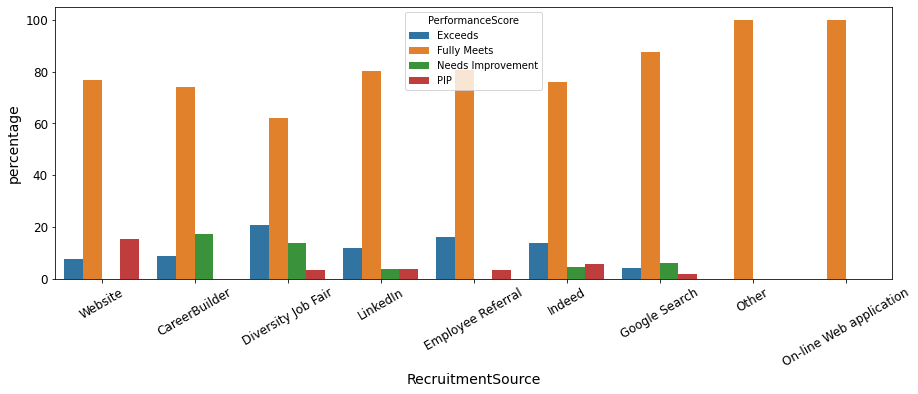

In [25]:
plt.figure(figsize=(15,5))
dfPandas= df.toPandas()
perfscore_percentage = (dfPandas.groupby(['RecruitmentSource'])['PerformanceScore']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('PerformanceScore'))
sbs.barplot(x="RecruitmentSource", y="percentage", hue="PerformanceScore", data=perfscore_percentage)
plt.xticks(rotation = 30)

## Data Preprocessing ##
Filling empty fields with default values. Additionally date columns will be converted into a long data type from string. Creation of an additional column "DaysWorked" which calculates the tenure of an employee out of the columns "DateofHire" and "DateofTermination".

In [26]:
# Fill null values
df = df.na.fill( {'TermReason': 'Unknown', 'ManagerID': 0, 'DaysLateLast30': 0, 'DateofTermination': '1/01/2021', 'LastPerformanceReview_Date': '1/01/2021'} )

# Converte date-strings to dates
df = df.withColumn('DateofHire', unix_timestamp(col('DateofHire'), 'M/dd/yyyy'))
df = df.withColumn('DOB', unix_timestamp(col('DOB'), 'MM/dd/yy'))
df = df.withColumn('DateofTermination', unix_timestamp(col('DateofTermination'), 'M/dd/yyyy'))
df = df.withColumn('LastPerformanceReview_Date', unix_timestamp(col('LastPerformanceReview_Date'), 'M/dd/yyyy'))

# Add new column for days worked in company
df = df.withColumn("DaysWorked", ((col("DateofTermination") - col("DateofHire"))/86400))

# Bucketizing Salary PayRate to hourly
df = df.withColumn('PayRate', (col('Salary')/2000))
bucketizer = Bucketizer(splits=[ 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, float('Inf') ],inputCol="PayRate", outputCol="PayRateBucket")
df = bucketizer.setHandleInvalid("keep").transform(df)

# Bucketizing Salary
bucketizer = Bucketizer(splits=[ 0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, float('Inf') ],inputCol="Salary", outputCol="SalaryBucket")
df = bucketizer.setHandleInvalid("keep").transform(df)

## Visualization of the pre processed data ## 
Creation of a Scatter plot based on the preprocessed dataframe and the additionally created column "DaysWorked". The Scatter graph shows on the x-axis the number of days an employee has worked in correlation to how much he earns. Additionally thorugh the colouring it can be identified which kind of employment status the employee has. For example the yellow points represent employees which have voluntarily terminated their employment.

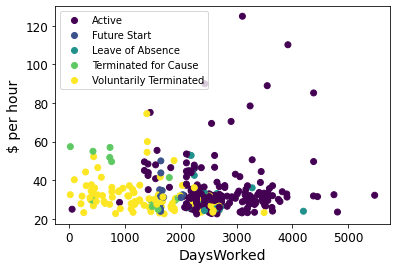

In [27]:
dfPandas = df.toPandas()
scatter = plt.scatter(dfPandas["DaysWorked"], dfPandas["PayRate"],c=dfPandas['EmpStatusID'])
plt.xlabel("DaysWorked")
plt.ylabel("$ per hour")
plt.legend(handles=scatter.legend_elements()[0],labels=['Active','Future Start','Leave of Absence','Terminated for Cause','Voluntarily Terminated'])
plt.show()

## Indexing the string columns ##
This part initializes the preprocessed data with the declaration of indices for the string columns in the dataframe. This enables the usage of a dataframe consiting of only integers for further analysis with pyspark. This will be used in the code below for the declarated "labeledData".

In [28]:
termdIndexer = StringIndexer().setInputCol("Termd").setOutputCol("Termd-num").fit(df)


empLastnameIndexer = StringIndexer().setInputCol("EmpLastname").setOutputCol("EmpLastname-num").fit(df)
empFirstnameIndexer = StringIndexer().setInputCol("EmpFirstname").setOutputCol("EmpFirstname-num").fit(df)
positionIndexer = StringIndexer().setInputCol("Position").setOutputCol("Position-num").fit(df)
stateIdIndexer = StringIndexer().setInputCol("State").setOutputCol("State-num").fit(df)
sexIndexer = StringIndexer().setInputCol("Sex").setOutputCol("Sex-num").fit(df)
maritalDescIndexer = StringIndexer().setInputCol("MaritalDesc").setOutputCol("MaritalDesc-num").fit(df)
citizenDescIndexer = StringIndexer().setInputCol("CitizenDesc").setOutputCol("CitizenDesc-num").fit(df)
hispanicLatinoIndexer = StringIndexer().setInputCol("HispanicLatino").setOutputCol("HispanicLatino-num").fit(df)
raceDescIndexer = StringIndexer().setInputCol("RaceDesc").setOutputCol("RaceDesc-num").fit(df)
termReasonIndexer = StringIndexer().setInputCol("TermReason").setOutputCol("TermReason-num").fit(df)
empStatusIndexer = StringIndexer().setInputCol("EmploymentStatus").setOutputCol("EmploymentStatus-num").fit(df)
departmentIndexer = StringIndexer().setInputCol("Department").setOutputCol("Department-num").fit(df)
managerNameIndexer = StringIndexer().setInputCol("ManagerName").setOutputCol("ManagerName-num").fit(df)
recruitSourceIndexer = StringIndexer().setInputCol("RecruitmentSource").setOutputCol("RecruitmentSource-num").fit(df)
performanceScoreIndexer = StringIndexer().setInputCol("PerformanceScore").setOutputCol("PerformanceScore-num").fit(df)

# Removing Feature Columns #
Used to simplify the process.

In [29]:
print(df.printSchema())
featureCols = df.columns.copy()
featureCols.remove("EmpLastname")
featureCols.remove("EmpFirstname")
featureCols.remove("EmpID")
featureCols.remove("MarriedID")
featureCols.remove("MaritalStatusID")
featureCols.remove("GenderID")
#featureCols.remove("EmpStatusID")
featureCols.remove("DeptID")
featureCols.remove("PerfScoreID")
featureCols.remove("FromDiversityJobFairID")
featureCols.remove("Termd")
featureCols.remove("PositionID")
featureCols.remove("Position")
featureCols.remove("State")
featureCols.remove("Zip")
featureCols.remove("DOB")
featureCols.remove("Sex")
featureCols.remove("MaritalDesc")
featureCols.remove("CitizenDesc")
featureCols.remove("HispanicLatino")
featureCols.remove("RaceDesc")
featureCols.remove("DateofHire")
featureCols.remove("DateofTermination")
featureCols.remove("TermReason")
featureCols.remove("EmploymentStatus")
featureCols.remove("Department")
featureCols.remove("ManagerName")
featureCols.remove("ManagerID")
featureCols.remove("RecruitmentSource")
featureCols.remove("PerformanceScore")
#featureCols.remove("EngagementSurvey")
featureCols.remove("EmpSatisfaction")
#featureCols.remove("SpecialProjectsCount")
featureCols.remove("LastPerformanceReview_Date")
featureCols.remove("DaysLateLast30")
featureCols.remove("Absences")
#featureCols.remove("DaysWorked")
#featureCols.remove("PayRate")
featureCols.remove("PayRateBucket")
featureCols.remove("Salary")
featureCols.remove("SalaryBucket")



root
 |-- EmpLastname: string (nullable = true)
 |-- EmpFirstname: string (nullable = true)
 |-- EmpID: integer (nullable = true)
 |-- MarriedID: integer (nullable = true)
 |-- MaritalStatusID: integer (nullable = true)
 |-- GenderID: integer (nullable = true)
 |-- EmpStatusID: integer (nullable = true)
 |-- DeptID: integer (nullable = true)
 |-- PerfScoreID: integer (nullable = true)
 |-- FromDiversityJobFairID: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Termd: integer (nullable = true)
 |-- PositionID: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- DOB: long (nullable = true)
 |-- Sex: string (nullable = true)
 |-- MaritalDesc: string (nullable = true)
 |-- CitizenDesc: string (nullable = true)
 |-- HispanicLatino: string (nullable = true)
 |-- RaceDesc: string (nullable = true)
 |-- DateofHire: long (nullable = true)
 |-- DateofTermination: long (nullable = tru

In [30]:
assembler =  VectorAssembler(outputCol="features", inputCols=list(featureCols), handleInvalid='skip')
#labeledData = empLastnameIndexer.transform(df)
#print(labeledData.printSchema())

## Creation of labeledData based on string indexed columns ##
Assembly of the defined feature columns and creation of a string indexer transformed dataframe.

In [31]:
#labeledData = empLastnameIndexer.transform(df)
# pipeline all indexers
#indexedLabeledData = positionIndexer.transform(stateIdIndexer.transform(sexIndexer.transform(maritalDescIndexer.transform(citizenDescIndexer.transform(hispanicLatinoIndexer.transform(raceDescIndexer.transform(termReasonIndexer.transform(empStatusIndexer.transform(departmentIndexer.transform(managerNameIndexer.transform(recruitSourceIndexer.transform(performanceScoreIndexer.transform(empFirstnameIndexer.transform(labeledData))))))))))))))
#labeledPointData = assembler.transform(indexedLabeledData)
#DEBUG labeledPointData.show()

## KMeans ##
Creating VectorAssembler for the columns

In [32]:
vecAssembler = VectorAssembler(inputCols=["PayRate", "DaysWorked", "EngagementSurvey", "SpecialProjectsCount"], outputCol="features")
new_df = vecAssembler.transform(df)


## Preparation For Clustering ##

In [33]:
kmeans = KMeans(k=5, seed=1337)

# Split data
splits = new_df.randomSplit([0.95, 0.05 ], 420)
training = splits[0]
test = splits[1]


## Displaying Trained Clusters ##

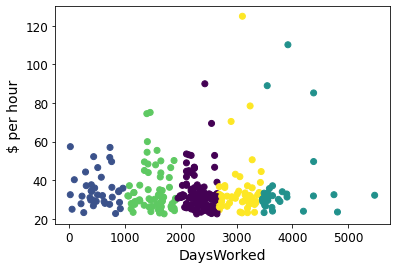

In [34]:
model = kmeans.fit(training.select('features'))
train_model = model.transform(training)

pddf_pred = train_model.toPandas().set_index('EmpID')
pddf_pred.head()
scatter = plt.scatter(pddf_pred.DaysWorked, pddf_pred.PayRate, c=pddf_pred.prediction)
plt.xlabel("DaysWorked")
plt.ylabel("$ per hour")
plt.show()

## Evaluated Clusters ##

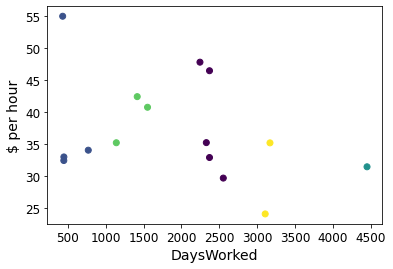

In [35]:
evaluate_model = model.transform(test)

pddf_pred = evaluate_model.toPandas().set_index('EmpID')
pddf_pred.head()
scatter = plt.scatter(pddf_pred.DaysWorked, pddf_pred.PayRate, c=pddf_pred.prediction)
plt.xlabel("DaysWorked")
plt.ylabel("$ per hour")
plt.show()

## Getting prediction on basis of clustering ## 

In [36]:
# Writing columns into dict
eval_dict = evaluate_model.toPandas().set_index('EmpID').T.to_dict('list')
#print(eval_dict)
job_status = ['will stay.', 'will terminate.', 'will stay.', 'will terminate.', 'will stay.']
for empID in eval_dict:
    print("{0} {1} earns {2:.0f} dollars per hour with {3:.0f} days worked and {4}"
          .format(
              eval_dict[empID][1],
              eval_dict[empID][0],
              eval_dict[empID][-5],
              eval_dict[empID][-6],
              job_status[int(eval_dict[empID][-1])]
          )
         )

Sarah Akinkuolie earns 32 dollars per hour with 447 days worked and will terminate.
Colby Andreola earns 48 dollars per hour with 2244 days worked and will stay.
Renee Becker earns 55 dollars per hour with 432 days worked and will terminate.
Mia Brown earns 32 dollars per hour with 4449 days worked and will stay.
David Gordon earns 24 dollars per hour with 3105 days worked and will stay.
Alfred Hitchcock earns 35 dollars per hour with 2328 days worked and will stay.
Ming Huynh earns 34 dollars per hour with 770 days worked and will terminate.
Lindsey Langford earns 33 dollars per hour with 448 days worked and will terminate.
Binh Le earns 41 dollars per hour with 1552 days worked and will terminate.
Giovanni Leruth earns 35 dollars per hour with 3168 days worked and will stay.
Louis Punjabhi earns 30 dollars per hour with 2552 days worked and will stay.
Andrew Szabo earns 46 dollars per hour with 2370 days worked and will stay.
Charlie Wang earns 42 dollars per hour with 1416 days work

## Building Evaluator and calculating distances ##

In [37]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(train_model)
print("Silhouette with squared euclidean distance = " + str(silhouette))

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6766397020968253
Cluster Centers: 
[3.31744112e+01 2.33859813e+03 4.11728972e+00 1.43925234e+00]
[ 35.23352703 519.05405405   4.10594595   1.45945946]
[3.71466833e+01 3.85566667e+03 4.14733333e+00 9.33333333e-01]
[3.45861406e+01 1.52101562e+03 4.04421875e+00 1.14062500e+00]
[3.44007241e+01 3.03587931e+03 4.14086207e+00 6.20689655e-01]


# Random Forest #

In [38]:
labledPointDataSet = new_df
splits = labledPointDataSet.randomSplit([0.9, 0.1 ], 420)
training = splits[0]
test = splits[1]

Random Forest Classifier

In [39]:
rf = RandomForestClassifier(labelCol="Termd", featuresCol="features",impurity="gini", \
                 minInstancesPerNode=10, featureSubsetStrategy='sqrt', subsamplingRate=0.95, seed= 12345)

Train the model 

In [40]:
rfModel = rf.fit(training)

Test the model

In [43]:
predictions = rfModel.transform(test)
predictions.show(1)

+-----------+------------+-----+---------+---------------+--------+-----------+------+-----------+----------------------+------+-----+----------+--------------------+-----+----+---------+---+-----------+-----------+--------------+--------+----------+-----------------+----------+--------------------+-----------------+--------------+---------+-----------------+----------------+----------------+---------------+--------------------+--------------------------+--------------+--------+----------+-------+-------------+------------+--------------------+--------------------+--------------------+----------+
|EmpLastname|EmpFirstname|EmpID|MarriedID|MaritalStatusID|GenderID|EmpStatusID|DeptID|PerfScoreID|FromDiversityJobFairID|Salary|Termd|PositionID|            Position|State| Zip|      DOB|Sex|MaritalDesc|CitizenDesc|HispanicLatino|RaceDesc|DateofHire|DateofTermination|TermReason|    EmploymentStatus|       Department|   ManagerName|ManagerID|RecruitmentSource|PerformanceScore|EngagementSurvey|E

In [42]:
evaluator = BinaryClassificationEvaluator(labelCol="Termd",rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)
print("Test Error",(1.0 - accuracy))

Test Error 0.10096153846153855
